In [7]:
import numpy as np
import random
import matplotlib.pyplot as plt
import sys


class progressBar:
    toolbarWidth = 100
    lastUpdate = 0

    def __init__(self):
        self.toolbarWidth = 100


    def updateBar(self, i, N):
        progress = i / N
        progressBits = progress * self.toolbarWidth

        delta = int(np.floor(progressBits) - self.lastUpdate)
        for i in range(0, delta):
            sys.stdout.write("-")
            sys.stdout.flush()
        self.lastUpdate = np.floor(progressBits)

    def finishBar(self):
        sys.stdout.write("]\n")


def potential(x):
    return x ** 2 / 2


def changePos(posValue, epsilon):  # flip a dipole value
    return posValue + random.random() * epsilon * 2 - epsilon


def configPlot(config):  # output the current config
    print(config)


def configAction(config,):  # config energy of the ising chain in Joule
    N = len(config) - 1

    sum = 0
    term = 0

    for i in range(0, N):  # go through the sum
        term = (config[i + 1] - config[i]) ** 2 + 0.5 * potential(config[i])

        sum = sum + term
    # calculate energy from the sum with J = 1
    action = sum  # config energy in Joule
    return action


def configProbability(oldConfig, newConfig):
    # probability of trial config to be accepted
    dAction = deltaAction(oldConfig, newConfig)
    probability = np.exp(-(dAction))
    return probability


def deltaAction(oldConfig, newConfig):
    oldAction = configAction(oldConfig)
    newAction = configAction(newConfig)
    deltaAction = oldAction - newAction
    return deltaAction


def setConfig(N, coldStart):
    config = np.empty(N + 1)

    # initial setup ising chain
    for i in range(0, N):  # set dipoles randomly to 1 or -1
        if coldStart:
            position = 0
        else:
            position = random.random() * 2 - 1

        config[i] = position
    config[N] = config[0]
    return config


def updateConfig(oldConfig, epsilon):
    # set trial config to current config

    N = len(oldConfig) - 1

    changePosNo = random.randint(0, N)

    # change the position
    trialConfig = oldConfig
    trialConfig[changePosNo] = changePos(trialConfig[changePosNo], epsilon)

    if deltaAction(oldConfig, trialConfig) < 0:
        newConfig = trialConfig
    else:
        # calculate probabiliy from the configs via Action
        p = configProbability(oldConfig, trialConfig)

        # generate random number r between 0 and 1
        r = random.random()
        # decide if trial config is accepted
        if p >= r:
            # accept trial config
            newConfig = trialConfig
        else:
            # dont change Config
            newConfig = oldConfig
    return newConfig


def thermalizeConfig(freshConfig, updates, epsilon):
    thermalized = freshConfig
    for k in range(0, updates):
        thermalized = updateConfig(thermalized, epsilon)
    return thermalized


def getSamples(config, samples, updates, epsilon):
    print(
        "Sample calculation for ",
        samples,
        " samples and ",
        updates,
        " updates between samples:",
    )
    bar = progressBar()

    N = len(config) - 1
    allConfigs = np.empty((N + 1, samples + 1))
    allConfigs[:, 0] = config

    for alpha in range(1, samples + 1):
        oldConfig = allConfigs[:, alpha]
        for k in range(0, updates):
            oldConfig = updateConfig(oldConfig, epsilon)

        allConfigs[:, alpha] = oldConfig
        bar.updateBar(alpha + 1, samples + 1)
    bar.finishBar()

    allConfigs = allConfigs[:, 1 : samples + 1]
    return allConfigs





Sample calculation for  500  samples and  50  updates between samples:
----------------------------------------------------------------------------------------------------]


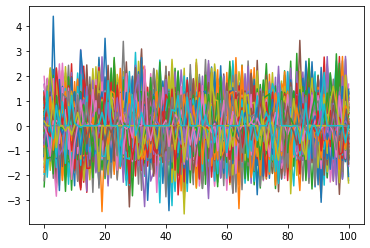

In [10]:

# parameters
N = 100

Ncf = 500
Ncr = 50

epsilon = 1.4

# set config
config = setConfig(N, coldStart=False)

# thermalize configs
thermalizedConfig = thermalizeConfig(config, 5 * Ncr, epsilon)


# select uncorrelated configs
uncorrConfigs = getSamples(thermalizedConfig, Ncf, Ncr, epsilon)

plt.plot(uncorrConfigs)
plt.show()


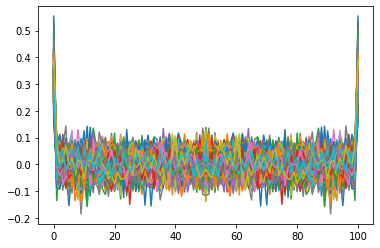

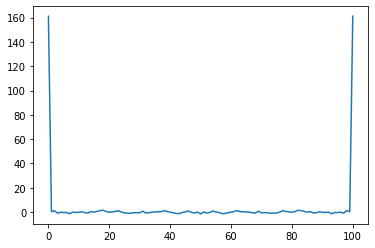

In [12]:

# calculate greens function

def greensFunction(config, n):
    N = len(config) - 1

    sum = 0
    for j in range(0, N):
        sum = sum + config[(j + n) % N] * config[j]
    return sum / N


def calculateG(configs):
    Ncf = len(configs[0, :])
    N = len(configs[:, 0])

    G = np.empty((N, Ncf))

    for alpha in range(0, Ncf):
        for n in range(0, N):
            G[n, alpha] = greensFunction(configs[:, alpha], n)

    return G


G = calculateG(uncorrConfigs)

avgG = np.sum(G, axis=1)

plt.plot(G)
plt.show()

plt.plot(avgG)
plt.show()



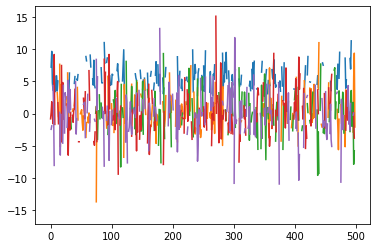

In [13]:
# calculate energy difference


def calculateDeltaE(G):
    Ncf = len(G[0, :])
    N = len(G[:, 0]) - 1

    deltaE = np.empty((N + 1, Ncf))

    for n in range(0, N):
        deltaE[n, :] = 2 * np.log(G[n, :] / G[n + 1, :])
    return deltaE


deltaE = calculateDeltaE(G)
plt.plot(deltaE[0, :])
plt.plot(deltaE[1, :])
plt.plot(deltaE[2, :])
plt.plot(deltaE[3, :])
plt.plot(deltaE[4, :])
plt.show()
